# Applied Machine Learning: In-class Exercise 04-1

## Goal

Learn how to rank features of a supervised task by their importance / strength of relationship with the target variable using a feature filter method.

## German Credit Dataset

We create the task as for the resampling exercise: the German Credit Dataset.

Your task is to construct a DataFrame (`X`) containing numerical features along with categorical features transformed by ordinal encoding.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OrdinalEncoder


rng = np.random.default_rng(seed=42)

X_raw, y = fetch_openml(name='credit-g', version=1, as_frame=True, return_X_y=True)

# Separate numerical and categorical features
categorical_features = X_raw.select_dtypes(include=['category', 'object']).columns
numerical_features = X_raw.select_dtypes(include=['int64', 'float64']).columns

# Extract numerical features as a dataframe
X_numerical = X_raw[numerical_features].copy()

# Apply ordinal encoding to categorical features
ordinal_encoder = OrdinalEncoder()
X_categorical_encoded = pd.DataFrame(
    ordinal_encoder.fit_transform(X_raw[categorical_features]),
    columns=categorical_features,
    index=X_raw.index
)
# Ensure the encoded features have int dtype
X_categorical_encoded = X_categorical_encoded.astype(int)

# Concatenate numerical and encoded categorical features
X = pd.concat([X_numerical, X_categorical_encoded], axis=1)
# Create a boolean vector indicating which features are discrete, will be used later
is_discrete = [col in categorical_features for col in X.columns]
is_discrete = np.array(is_discrete, dtype=bool)


## Exercises

Within the Python ecosystem, feature filters for selecting informative variables are available through the `sklearn.feature_selection` module in scikit-learn. Typically, these feature filters can be included as part of preprocessing pipelines (`sklearn.pipeline.Pipeline`). In exercises 1 to 3, we apply feature filtering directly on the processed DataFrame without using pipelines. In exercise 4, we will set up a pipeline combining a learner with feature filtering as a preprocessing step.

## Exercise 1: Find a suitable Feature Filter

Make yourself familiar with the functions and classes provided by the [`sklearn.feature_selection`](https://scikit-learn.org/stable/api/sklearn.feature_selection.html#module-sklearn.feature_selection) module. Identify which feature selection methods can be applied to datasets containing both numerical and encoded categorical features, like the one you created in the previous step.

## Exercise 2: Information Gain Filter

We now want to compute the information gain, also known as mutual information, for each feature. Mutual information measures how much knowing one feature reduces uncertainty about the target variable.

Create an information gain filter by using the function `mutual_info_classif()` from the `sklearn.feature_selection` module. Compute the information gain score for each feature in the DataFrame you created in the previous step.

Visualize the information gain scores for each feature, and based on these scores, decide how many and which features to include. Using a rule of thumb, e.g., the ‘’elbow rule’’ you can determine the number of features to include.

<details><summary>Hint 1:</summary>
You can use `mutual_info_classif(X, y)` to compute information gain scores.
</details>

<details><summary>Hint 2:</summary>
After calculating the scores, use matplotlib to create a bar plot for clear visualization.
</details>


Information Gain scores for each feature:
                   Feature  Information Gain
7          checking_status          0.065668
0                 duration          0.039110
8           credit_history          0.030234
10          savings_status          0.019488
4                      age          0.018392
9                  purpose          0.017255
14      property_magnitude          0.011773
1            credit_amount          0.011449
11              employment          0.009082
16                 housing          0.008840
6           num_dependents          0.008467
15     other_payment_plans          0.006152
12         personal_status          0.004721
19          foreign_worker          0.004036
13           other_parties          0.003325
17                     job          0.000927
18           own_telephone          0.000668
5         existing_credits          0.000000
3          residence_since          0.000000
2   installment_commitment          0.000000


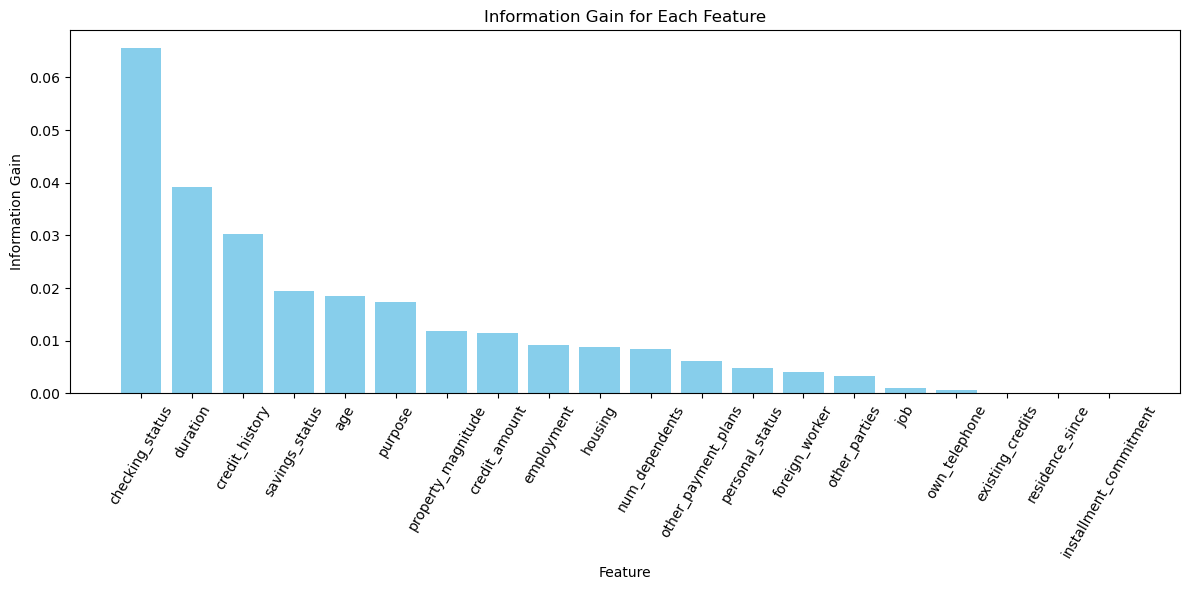

In [2]:
#===SOLUTION===

import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif


# Compute the information gain (mutual information) for each feature.
# mutual_info_classif returns an array of scores, one per feature.
mi_scores = mutual_info_classif(X, y, discrete_features=is_discrete, random_state=42)

# Create a DataFrame for the scores and sort by information gain (descending)
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Information Gain': mi_scores
}).sort_values(by='Information Gain', ascending=False)

print("\nInformation Gain scores for each feature:")
print(mi_df)

# Visualize the information gain scores using a bar plot.
plt.figure(figsize=(12, 6))
plt.bar(mi_df['Feature'], mi_df['Information Gain'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Information Gain')
plt.title('Information Gain for Each Feature')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

Question: which features will you include based on the Information Gain?

===SOLUTION===

Based on the plot above, we select `checking_status`, `duration`, and `saving_status`.

## Exercise 3: Create and Apply a Feature Filtering Pipeline

Since the k-NN learner suffers from the curse of dimensionality, we want to set up a preprocessing pipeline step to select the 5 most important features according to the information gain filter (mutual information). In Python, feature selection can easily be integrated into preprocessing pipelines using scikit-learn's `Pipeline` and `SelectKBest`.

Create a pipeline (`Pipeline`) that applies a feature filter (`SelectKBest`) using mutual information (`mutual_info_classif`) as the scoring function, and selects only the top 5 most important features from the German Credit Dataset. Apply this pipeline to your DataFrame (`X`) to produce a filtered dataset containing only the selected features.

After running the pipeline, report:

- The number of samples and features before and after filtering.
- The names of the features selected by the filter.

<details><summary>Hint 1:</summary>
Use `SelectKBest(score_func=mutual_info_classif, k=5)` inside a `Pipeline` to filter features.
</details>

In [3]:
#===SOLUTION===

from functools import partial
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

mi_score_fn = partial(mutual_info_classif, discrete_features=is_discrete)

# Create a feature selector that picks the 5 best features based on mutual information (information gain)
selector = SelectKBest(score_func=mi_score_fn, k=5)

pipe = Pipeline([
    ('feature_filter', selector)
])

X_filtered = pipe.fit_transform(X, y)

# Retrieve the names of the selected features
selected_features = X.columns[selector.get_support()]
print(f"Original task shape: {X.shape[0]} samples and {X.shape[1]} features.")
print(f"Filtered task shape: {X_filtered.shape[0]} samples and {X_filtered.shape[1]} features.")
print(f"Selected features based on Information Gain: {list(selected_features)}")


Original task shape: 1000 samples and 20 features.
Filtered task shape: 1000 samples and 5 features.
Selected features based on Information Gain: ['credit_amount', 'checking_status', 'credit_history', 'purpose', 'savings_status']


## Exercise 4: Combine Feature Filtering with a Learner

Perform the following tasks:

- Combine the feature filtering step from the previous exercise (`SelectKBest` with mutual information) with a k-NN classifier (`KNeighborsClassifier`) to create a scikit-learn `Pipeline` that sequentially filters features and then trains the classifier.

- Run a 5-fold cross-validation (`KFold`) to estimate the pipeline's performance, using the classification accuracy as a measure. Report the resulting error rate.

- Change the number of selected features (parameter `k`) from 5 to 2, and perform the cross-validation again to observe how this affects the error rate.

<details><summary>Hint 1:</summary>
Use `Pipeline` to combine `SelectKBest` and `KNeighborsClassifier`.
</details>

<details><summary>Hint 2:</summary>
Use `pipe.set_params()` to adjust the number of selected features (`k`) without redefining the entire pipeline.
</details>

In [4]:
#===SOLUTION===

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Create a preprocessor that scales only the numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [i for i, is_disc in enumerate(is_discrete) if not is_disc])
    ],
    remainder='passthrough'
)

# Build the pipeline: preprocessing, feature filtering, then a k-NN classifier
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_filter', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('knn', KNeighborsClassifier(n_neighbors=15))
])

scores = cross_val_score(pipe, X, y, cv=kf, scoring='accuracy')
error_rate = 1 - np.mean(scores)
print(f"5-Fold CV Error Rate (with 5 selected features): {error_rate:.3f}")

# Now, change the number of selected features to 2.
pipe.set_params(feature_filter__k=2)

scores2 = cross_val_score(pipe, X, y, cv=kf, scoring='accuracy')
error_rate2 = 1 - np.mean(scores2)
print(f"5-Fold CV Error Rate (with 2 selected features): {error_rate2:.3f}")

5-Fold CV Error Rate (with 5 selected features): 0.268
5-Fold CV Error Rate (with 2 selected features): 0.282


## Summary

We learned how to use feature filters to rank the features w.r.t. a feature filter method in a supervised setting and how to subset a task accordingly.

Ideally, feature filtering is directly incorporated into the learning procedure by making use of a pipeline so that performance estimation after feature filtering is not biased.